# Improving EMOSPEECH with A Continuous Emotion Embedding Space


---

**Section:** 61U

**Group members:**


*   Ghaida Ayesh Alalyani | 444009035
*   Dinah Muhammed Alharbi | 444009037
*   Yara Fahad Alshedokhi | 444009012
*   Nura Ibrahim Alolayan | 444009025



---

This project was based on EMOSPEECH (https://github.com/deepvk/emospeech)



# Preprocessing

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import os
import numpy as np
import torch.nn.functional as F

## Classification data

In [ ]:
classification_df = pd.read_csv("/content/emotion_sentimen_dataset.csv")
classification_df

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral
...,...,...,...
839550,839550,i feel like telling these horny devils to find...,neutral
839551,839551,i began to realize that when i was feeling agi...,neutral
839552,839552,i feel very curious be why previous early dawn...,neutral
839553,839553,i feel that becuase of the tyranical nature of...,neutral


In [ ]:
classification_df.drop("Unnamed: 0", inplace=True, axis = 1) #remove extra index column

In [ ]:
classification_df.duplicated().sum() #count duplicates

np.int64(445733)

In [ ]:
classification_df = classification_df.drop_duplicates() #remove all duplicate rows

In [ ]:
classification_df["Emotion"].value_counts()

,count
Emotion,
neutral,316935
love,17634
happiness,13038
sadness,8485
relief,8007
hate,6160
anger,5952
fun,4854
enthusiasm,4497


In [ ]:
# Filter classes to only contain those similar to the ones in the ESD dataset
desired_classes = ["neutral", "happiness", "sadness", "anger", "surprise"]
classification_df = classification_df[classification_df["Emotion"].isin(desired_classes)].copy()

In [ ]:
classification_df["Emotion"].value_counts()

,count
Emotion,
neutral,316935
happiness,13038
sadness,8485
anger,5952
surprise,3430


In [ ]:
# Down sample class row counts to the one with the lowest count to ensure class balance

classes = []
for class_name in desired_classes:
    class_df = classification_df[classification_df['Emotion'] == class_name]

    if len(class_df) >= 3430 : #length of the class with the lowest count (surprise)
        classes.append(class_df.sample(3430, random_state=42))

classification_df = pd.concat(classes).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
classification_df["Emotion"].value_counts()

,count
Emotion,
happiness,3430
surprise,3430
sadness,3430
neutral,3430
anger,3430


In [ ]:
# Replace emotion labels with the same ones used in EMOSPEECH (numerical)

class_mapping = {
    'neutral': 0,
    'anger': 1,
    'happiness': 2,
    'sadness': 3,
    'surprise': 4
}

classification_df['Emotion'] = classification_df['Emotion'].map(class_mapping).astype(int)

In [ ]:
classification_df["Emotion"].value_counts()

,count
Emotion,
2,3430
4,3430
3,3430
0,3430
1,3430


In [ ]:
# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    classification_df["text"].values,
    classification_df['Emotion'].values,
    test_size=0.2,
    random_state=42)

In [ ]:
# BERT tokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Classification dataset class

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }



In [ ]:
# Define dataset
max_len = 128
train_dataset = ClassificationDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = ClassificationDataset(val_texts, val_labels, tokenizer, max_len)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## CVAE data

In [ ]:
! unzip /content/mel-spectrograms.zip

Streaming output truncated to the last 5000 lines.
  inflating: mel/7_143_0.npy         
  inflating: mel/7_143_1.npy         
  inflating: mel/7_143_2.npy         
  inflating: mel/7_143_3.npy         
  inflating: mel/7_143_4.npy         
  inflating: mel/7_144_0.npy         
  inflating: mel/7_144_1.npy         
  inflating: mel/7_144_2.npy         
  inflating: mel/7_144_3.npy         
  inflating: mel/7_144_4.npy         
  inflating: mel/7_145_0.npy         
  inflating: mel/7_145_1.npy         
  inflating: mel/7_145_2.npy         
  inflating: mel/7_145_3.npy         
  inflating: mel/7_145_4.npy         
  inflating: mel/7_146_0.npy         
  inflating: mel/7_146_1.npy         
  inflating: mel/7_146_2.npy         
  inflating: mel/7_146_3.npy         
  inflating: mel/7_146_4.npy         
  inflating: mel/7_147_0.npy         
  inflating: mel/7_147_1.npy         
  inflating: mel/7_147_2.npy         
  inflating: mel/7_147_3.npy         
  inflating: mel/7_147_4.npy         

In [ ]:
# Processes the train-val-test split files (taken from the emospeech repo)
def process_meta(filename: str) -> tuple[np.ndarray, ...]:
        with open(filename, "r", encoding="utf-8") as f:
            speaker, name, emotion, phonemes, text = [], [], [], [], []
            for line in f.readlines():
                # Extract information from file
                s, n, e, p, t = line.strip("\n").split("|")
                name.append(int(n))
                speaker.append(int(s))
                emotion.append(int(e))
                phonemes.append(p)
                text.append(t)
            return np.array(speaker), np.array(name), np.array(emotion), np.array(phonemes), np.array(text)

### Mel sprectrogram dataset class

In [ ]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, root_dir, speaker_ids, file_ids, emotion_ids, target_n_mels = 128, target_time_steps = 80):
        self.root_dir = root_dir
        self.target_n_mels = target_n_mels
        self.target_time_steps = target_time_steps
        self.basenames = [
            f"{speaker_id}_{file_id}_{emotion_id}"
            for speaker_id, file_id, emotion_id in zip(speaker_ids, file_ids, emotion_ids)
        ]

        # Verify files exist
        self.valid_files = []
        self.labels = []
        for basename in self.basenames:
            file_path = os.path.join(root_dir, f"{basename}.npy")
            if os.path.exists(file_path):
                self.valid_files.append(file_path)
                emotion = basename.split("_")[-1]  # Extract emotion from basename
                self.labels.append(emotion)
            else:
                print(f"Warning: File {file_path} not found. Skipping.")

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Load spectrogram from .npy file
        file_path = self.valid_files[idx]

        # process spectrogram
        spectrogram = self.process_spectrogram(file_path, self.target_n_mels, self.target_time_steps)

        # one hot encode emotion labels
        label = self.labels[idx]
        label_onehot = F.one_hot(torch.tensor(int(label)), num_classes=5).float()

        return spectrogram, label_onehot

    def pad_spectrogram(self, spectrogram, target_n_mels, target_time_steps):

      # Pad n_mels and time_steps
      pad_n_mels = max(0, target_n_mels - spectrogram.shape[0])
      pad_time = max(0, target_time_steps - spectrogram.shape[1])

      # Pad symmetrically (top/bottom for n_mels, left/right for time_steps)
      padded = np.pad(
          spectrogram,
          ((0, pad_n_mels), (0, pad_time)),
          mode='constant',
          constant_values=0
      )

      return padded[:target_n_mels, :target_time_steps]  # Ensure exact size

    def clip_spectrogram(self, spectrogram, target_n_mels, target_time_steps):

        # Center-crop n_mels and time_steps
        start_mels = (spectrogram.shape[0] - target_n_mels) // 2
        start_time = (spectrogram.shape[1] - target_time_steps) // 2

        clipped = spectrogram[
            start_mels : start_mels + target_n_mels,
            start_time : start_time + target_time_steps
        ]
        return clipped

    def standardize_spectrogram(self, spectrogram, target_n_mels, target_time_steps):

        # Pad if smaller, clip if larger
        if spectrogram.shape[0] < target_n_mels or spectrogram.shape[1] < target_time_steps:
            spectrogram = self.pad_spectrogram(spectrogram, target_n_mels, target_time_steps)
        else:
            spectrogram = self.clip_spectrogram(spectrogram, target_n_mels, target_time_steps)
        return spectrogram

    def normalize_spectrogram(self, spectrogram):

        # Normalize spectrogram values to between 0 and 1
        spectrogram_min = spectrogram.min()
        spectrogram_max = spectrogram.max()
        return (spectrogram - spectrogram_min) / (spectrogram_max - spectrogram_min + 1e-8)  # Avoid division by zero

    def process_spectrogram(self, spectrogram_path, target_n_mels, target_time_steps):

        # Load as numpy array
        spectrogram = np.load(spectrogram_path)

        # Standardize shape
        spectrogram = self.standardize_spectrogram(spectrogram, target_n_mels, target_time_steps)

        # Normalize to [0, 1]
        spectrogram = self.normalize_spectrogram(spectrogram)

        # Convert to tensor and add channel dimension
        spectrogram = torch.from_numpy(spectrogram).float().unsqueeze(0)

        return spectrogram

In [ ]:
# Extract info from file
speaker_id, file_id, emotion_id, _ , _ = process_meta(filename= "/content/train.txt")

# Initialize dataset
dataset = MelSpectrogramDataset(
    "/content/mel",
    speaker_id,
    file_id,
    emotion_id,
)

# train-val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Create test dataset

# Extract info from file
speaker_id, file_id, emotion_id, _ , _ = process_meta(filename= "/content/val.txt")

# Initialize dataset
test_dataset = MelSpectrogramDataset(
    "/content/mel",
    speaker_id,
    file_id,
    emotion_id,
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Adapter dataset

In [ ]:
df = pd.read_csv("/content/processed_text_data.csv")

In [ ]:
# modified process meta for this dataset to be able to process dataframes
def process_meta_from_dataframe(df):
    speaker, name, emotion, text = [], [], [], []

    for idx, row in df.iterrows():
        # Extract speaker id, file number, and emotion
        s, n, e = row.iloc[0].split("|")

        speaker.append(int(s))
        name.append(int(n))
        emotion.append(int(e))
        text.append(row.iloc[1].rstrip())

    return (
        np.array(speaker),
        np.array(name),
        np.array(emotion),
        np.array(text)
    )

In [ ]:
speaker_id, file_id, emotion_id, text = process_meta_from_dataframe(df)

In [ ]:
# create a dataset for each model

# spectrogram data
adpater_spec_ds = MelSpectrogramDataset(
    "/content/mel",
    speaker_id,
    file_id,
    emotion_id,
)

# train-val split
train_size = int(0.8 * len(adpater_spec_ds))
val_size = len(adpater_spec_ds) - train_size

adap_spec_train_dataset, adap_spec_val_dataset = random_split(
    adpater_spec_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)


adap_spec_trainLoader = DataLoader(adap_spec_train_dataset, batch_size=32, shuffle=True)
adap_spec_valLoader = DataLoader(adap_spec_val_dataset, batch_size=32, shuffle=False)

# text data
bert_train_texts, bert_val_texts, bert_train_labels, bert_val_labels = train_test_split(
    text,
    emotion_id,
    test_size=0.2,
    random_state=42)

max_len = 128
adap_text_trainDataset = ClassificationDataset(bert_train_texts, bert_train_labels, tokenizer, max_len)
adap_text_valDataset = ClassificationDataset(bert_val_texts, bert_val_labels, tokenizer, max_len)

# Create DataLoaders
batch_size = 16
adap_text_trainLoader = DataLoader(adap_text_trainDataset, batch_size=batch_size, shuffle=True)
adap_text_valLoader = DataLoader(adap_text_valDataset, batch_size=batch_size, shuffle=False)

### Adapter dataset class

In [ ]:
class AdapterDataset(Dataset):
    def __init__(self, text_dataset, spectrogram_dataset, bert_model, cvae_encoder,device):

        self.text_dataset = text_dataset
        self.spectrogram_dataset = spectrogram_dataset
        self.bert_model = bert_model
        self.cvae_encoder = cvae_encoder

        # Verify that they are the same size
        assert len(text_dataset) == len(spectrogram_dataset)

    def __len__(self):
        return len(self.text_dataset)

    def __getitem__(self, idx):
        # Get precomputed BERT embeddings (frozen)
        text_data = self.text_dataset[idx]
        with torch.no_grad():
            text_embed = self.bert_model(
                input_ids=text_data["input_ids"].unsqueeze(0).to(device),
                attention_mask=text_data["attention_mask"].unsqueeze(0).to(device)
            ).squeeze(0)

        # Get target speech embeddings (frozen)
        spectrogram, label = self.spectrogram_dataset[idx]
        with torch.no_grad():
            _,_, speech_embed = self.cvae_encoder(spectrogram.unsqueeze(0).to(device), label.to(device))  # [1, embed_dim]

            speech_embed = speech_embed.squeeze(0)

        return {
            "text_embedding": text_embed,
            "speech_embedding": speech_embed,
            "label": text_data["label"]
        }

# Models

In [ ]:
from torch.optim import AdamW
import torch.optim as optim
from tqdm import tqdm
from transformers import BertForSequenceClassification

import torch.nn as nn
from torch.distributions.normal import Normal

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Classification with BERT

In [ ]:
# Model setup
model = BertForSequenceClassification.from_pretrained( "bert-base-uncased",
                                                        num_labels=5,
                                                        hidden_dropout_prob=0.2,
                                                        attention_probs_dropout_prob=0.2)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training

epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)

    # iterates through train loader
    for batch in loop:
        optimizer.zero_grad()
        # takes tokenized data and prepares to send it to the model
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # computes loss and backpropgates it
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # display epoch and last computed loss in the epoch
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch} Loss: {total_loss / len(train_loader)}")

Epoch 0: 100%|██████████| 858/858 [04:58<00:00,  2.87it/s, loss=0.00917]


Epoch 0 Loss: 0.34109996881885213


Epoch 1: 100%|██████████| 858/858 [04:57<00:00,  2.88it/s, loss=0.0142]


Epoch 1 Loss: 0.04405125513638094


Epoch 2: 100%|██████████| 858/858 [04:58<00:00,  2.87it/s, loss=0.00122]


Epoch 2 Loss: 0.022502982371192564


In [ ]:
# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    # iterates through validation loader
    for batch in val_loader:
        # takes tokenized data and prepares to send it to the model
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        # add the number of correct labels to correct
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# accuracy for the entire validation loader
accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9942


In [ ]:
# Save model
model.save_pretrained("bert_emotion_classifier")
tokenizer.save_pretrained("bert_emotion_classifier")

('bert_emotion_classifier/tokenizer_config.json',
 'bert_emotion_classifier/special_tokens_map.json',
 'bert_emotion_classifier/vocab.txt',
 'bert_emotion_classifier/added_tokens.json')

In [ ]:
# Zip into file for easier download (uncomment if neccesary)
# !zip -r '/content/bert_emotion_classifier.zip' '/content/bert_emotion_classifier'

  adding: content/bert_emotion_classifier/ (stored 0%)
  adding: content/bert_emotion_classifier/tokenizer_config.json (deflated 75%)
  adding: content/bert_emotion_classifier/model.safetensors (deflated 7%)
  adding: content/bert_emotion_classifier/special_tokens_map.json (deflated 42%)
  adding: content/bert_emotion_classifier/config.json (deflated 53%)
  adding: content/bert_emotion_classifier/vocab.txt (deflated 53%)


In [ ]:
class BertForEmbeddings(torch.nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        self.bert = trained_model.bert

    def forward(self, **inputs):
        outputs = self.bert(**inputs)
        return outputs.last_hidden_state[:, 0, :]  # CLS token

In [ ]:
# Uncomment if you need to load the model
# !unzip /content/bert_emotion_classifier.zip
# model = BertForSequenceClassification.from_pretrained("/content/bert_emotion_classifier/content/bert_emotion_classifier")
# tokenizer = BertTokenizer.from_pretrained("/content/bert_emotion_classifier/content/bert_emotion_classifier")


# embedding_model = BertForEmbeddings(model)
# embedding_model.to(device)


BertForEmbeddings(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## CVAE

In [ ]:
class ResidualBlock(nn.Module):
  # Introduces skip connections into the encoder and decoder architectures
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual  # Skip connection
        return self.relu(out)

In [ ]:
class Sampling(nn.Module):
  # This will preform the reparameterization trick
    def forward(self, z_mean, z_log_var):
        batch, dim = z_mean.shape
        epsilon = Normal(0, 1).sample((batch, dim)).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [ ]:
class Encoder(nn.Module):
  # Encoder that takes the data and the condition and outputs the latent variable z
    def __init__(self, input_channels, latent_dim, class_size):
        super().__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels + class_size, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.res_blocks = nn.Sequential(
            ResidualBlock(32, 64, stride=2),
            ResidualBlock(64, 128, stride=2),
        )
        self.fc_mu = nn.Linear(128 * (128 // 8) * (80 // 8), latent_dim)
        self.fc_logvar = nn.Linear(128 * (128 // 8) * (80 // 8), latent_dim)

        self.sampling = Sampling()

    def forward(self, x, c):
        c_cond = c.view(-1, 5, 1, 1)
        c_cond = c_cond.expand(-1, -1, x.shape[2], x.shape[3])
        x_cond = torch.cat([x, c_cond], dim=1)  # concatenate data and one hot encoded emotion

        x = self.initial_conv(x_cond)
        x = self.res_blocks(x)
        x = x.view(x.size(0), -1)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.sampling(mu, logvar) # reparameterization trick
        return mu, logvar, z

In [ ]:
class Decoder(nn.Module):
  # Decoder that takes the latent variable z and the condition and outputs the reconstructed data
    def __init__(self, latent_dim, output_channels, class_size):
        super().__init__()
        self.fc = nn.Linear(latent_dim + class_size, 128 * (128 // 8) * (80 // 8))
        self.res_blocks = nn.Sequential(
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2),
            ResidualBlock(64, 64),
            nn.Upsample(scale_factor=2),
            ResidualBlock(64, 32),
            nn.Upsample(scale_factor=2)
        )
        self.final_conv = nn.Conv2d(32, output_channels, kernel_size=7, padding=3)

    def forward(self, z, c):
        z_cond = torch.cat([z, c], dim=1)  # concatenate latent z and one hot encoded emotion condition

        x = self.fc(z_cond)
        x = x.view(-1, 128, 128 // 8, 80 // 8)
        x = self.res_blocks(x)

        return torch.sigmoid(self.final_conv(x))

In [ ]:
class CVAE(nn.Module):
  # combines the encoder and decoder
    def __init__(self, encoder, decoder):
        super(CVAE, self).__init__()
        # initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x, c):
        # pass the input through the encoder to get the latent vector
        z_mean, z_log_var, z = self.encoder(x,c)
        # pass the latent vector through the decoder to get the reconstructed data
        reconstruction = self.decoder(z,c)
        # return the mean, log variance and the reconstructed data
        return z_mean, z_log_var, reconstruction

In [ ]:
# cvae loss functions

# KL loss
def cvae_gaussian_kl_loss(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return KLD.mean()

# reconstruction loss (BCE)
def reconstruction_loss(x_reconstructed, x):
    bce_loss = nn.BCELoss()
    return bce_loss(x_reconstructed, x)

# combined CVAE loss
def cvae_loss(y_pred, y_true):
    mu, logvar, recon_x = y_pred
    recon_loss = reconstruction_loss(recon_x, y_true)
    kld_loss = cvae_gaussian_kl_loss(mu, logvar)
    return 5 * recon_loss + 0.5 * kld_loss

In [ ]:
# instantiate models

encoder = Encoder(1, 256, 5).to(
    device
)

decoder = Decoder(
    256, 1, 5
).to(device)

cvae = CVAE(encoder, decoder)

# instantiate optimizer and scheduler
optimizer = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()), lr=0.001
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=2, verbose=True
)

In [ ]:
# for validation during training
from tqdm import tqdm

def validate(cvae, val_loader):
    cvae.eval()
    running_loss = 0.0

    with torch.no_grad():
        # iterate through the validation loader
        for batch_idx, (data, labels) in tqdm(
            enumerate(val_loader), total=len(val_loader)
        ):

            data, labels = data.to(device), labels.to(device)
            pred = cvae(data, labels)

            loss = cvae_loss(pred, data)
            running_loss += loss.item()

    # calculate the average loss over all batches
    return running_loss / len(val_loader)

In [ ]:
# create file to save best model weights
!touch Best_CVAE.pt

In [ ]:
# training

best_val_loss = float("inf")
epochs = 100

for epoch in range(epochs):
  cvae.train()
  running_loss = 0
  # iterate through the train loader
  for batch_idx, (data, labels) in enumerate(train_loader):
      data, labels = data.to(device), labels.to(device)
      pred = cvae(data, labels)

      # backward pass and optimizer step
      optimizer.zero_grad()
      loss = cvae_loss(pred, data)
      loss.backward()
      running_loss += loss.detach().cpu().numpy()
      optimizer.step()



  # compute average loss for the epoch
  train_loss = running_loss / len(train_loader)
  # compute validation loss for the epoch
  val_loss = validate(cvae , val_loader)

  # print training and validation loss at every 20 epochs
  if epoch % 20 == 0 or (epoch+1) == epochs:
      print(
          f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
      )
  # save best vae model weights based on validation loss
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(
          {"cvae": cvae.state_dict()},
          "/content/Best_CVAE.pt",
      )
  scheduler.step(val_loss)

100%|██████████| 94/94 [00:01<00:00, 52.86it/s]


Epoch 0 | Train Loss: 216698688.0000 | Val Loss: 4472.6009


100%|██████████| 94/94 [00:01<00:00, 53.57it/s]


Epoch 20 | Train Loss: 2061679616.0000 | Val Loss: 9109.7451


100%|██████████| 94/94 [00:02<00:00, 45.43it/s]


Epoch 40 | Train Loss: 213197936.0000 | Val Loss: 9015.2747


100%|██████████| 94/94 [00:01<00:00, 54.04it/s]


Epoch 60 | Train Loss: 84295392.0000 | Val Loss: 8861.6886


100%|██████████| 94/94 [00:01<00:00, 55.02it/s]


Epoch 80 | Train Loss: 11138739.0000 | Val Loss: 8912.0801


100%|██████████| 94/94 [00:01<00:00, 53.29it/s]

Epoch 99 | Train Loss: 8892.8320 | Val Loss: 8919.4545


In the following cell, we aim to answer two questions to ensure that the cvae properly captured the emotion space:



*   Are embeddings of **similar** emotions **close**?
*   Are embeddings of **differen** emotions **far**?



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


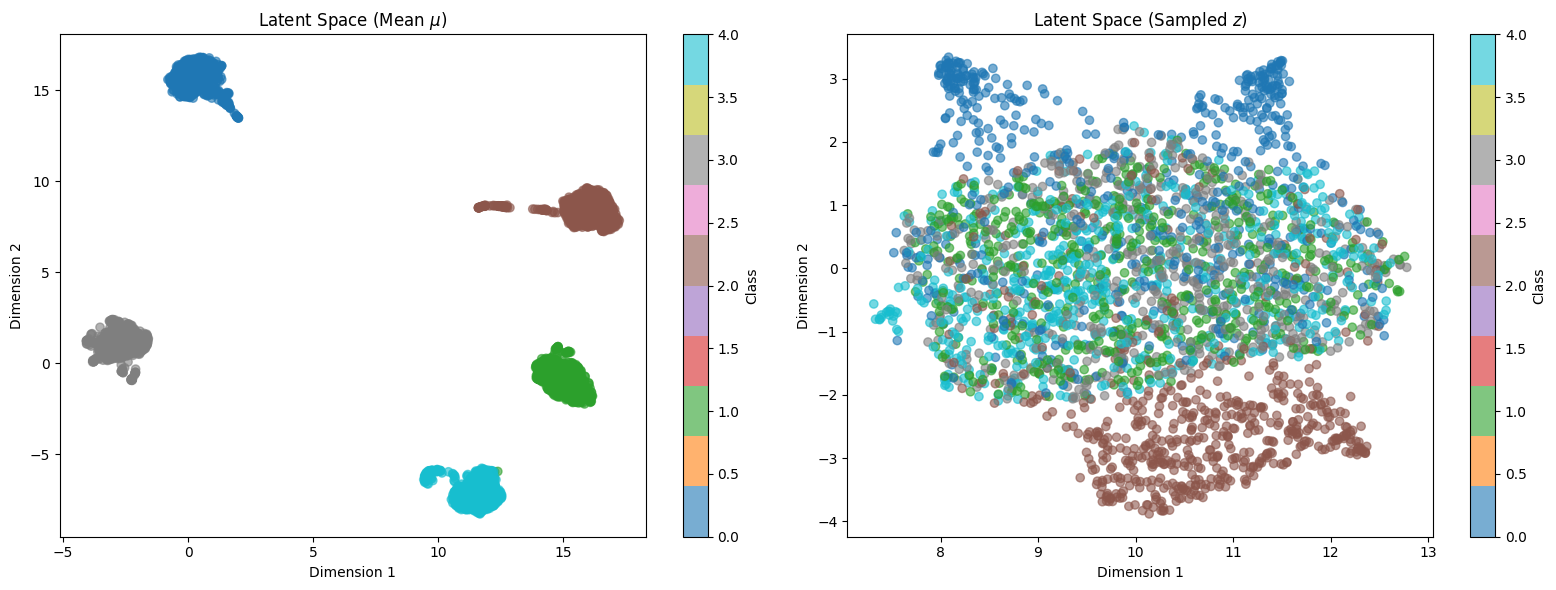

In [ ]:
# visualize the latent space with UMAP

import numpy as np
import matplotlib.pyplot as plt
import umap
import torch
from sklearn.preprocessing import LabelEncoder

def visualize_latent_space(encoder, dataloader):

    encoder.eval()
    all_mu, all_z, all_labels = [], [], []

    with torch.no_grad():
        for x, y_onehot in dataloader:
            x , y_onehot = x.to(device), y_onehot.to(device)
            mu, log_var, z = encoder(x, y_onehot)

            all_mu.append(mu.cpu())
            all_z.append(z.cpu())
            all_labels.append(y_onehot.argmax(dim=1).cpu())  # Convert one-hot to class indices

    # Concatenate all batches
    mu = torch.cat(all_mu, dim=0).numpy()
    z = torch.cat(all_z, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()

    # Reduce dimensionality for visualization
    reducer = umap.UMAP(random_state=42)

    mu_2d = reducer.fit_transform(mu)
    z_2d = reducer.fit_transform(z)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot mu (mean vectors)
    scatter1 = ax1.scatter(mu_2d[:, 0], mu_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    ax1.set_title('Latent Space (Mean $\mu$)')
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    fig.colorbar(scatter1, ax=ax1, label='Class')

    # Plot z (sampled vectors)
    scatter2 = ax2.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    ax2.set_title('Latent Space (Sampled $z$)')
    ax2.set_xlabel('Dimension 1')
    ax2.set_ylabel('Dimension 2')
    fig.colorbar(scatter2, ax=ax2, label='Class')

    plt.tight_layout()
    plt.show()

    return mu_2d, z_2d, labels


mu_2d, z_2d, labels = visualize_latent_space(encoder, val_loader)

In [ ]:
# uncomment to load CVAE
# encoder = Encoder(1, 256, 5).to(
#     device
# )

# decoder = Decoder(
#     256, 1, 5
# ).to(device)

# cvae = CVAE(encoder, decoder)

# cvae.load_state_dict(torch.load('/content/Best_CVAE.pt', weights_only=True)["cvae"])

<All keys matched successfully>

## Adapter

In [ ]:
# Created here because we need the previous models

# Create dataset
train_dataset = AdapterDataset(adap_text_trainDataset, adap_spec_train_dataset, embedding_model, cvae.encoder, device)
val_dataset = AdapterDataset(adap_text_valDataset, adap_spec_val_dataset, embedding_model, cvae.encoder, device)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle = False)

In [ ]:
class Adapter(nn.Module):
    def __init__(self, text_dim=768, speech_dim=256, bottleneck_dim=128):
        super().__init__()
        self.down = nn.Linear(text_dim, bottleneck_dim)
        self.up = nn.Linear(bottleneck_dim, speech_dim, bias=False) # removed bias to reduce parameters to prevent overfiiting on a small dataset
        self.residual = nn.Linear(text_dim, speech_dim, bias=False)  # Skip connection
        self.temperature = nn.Parameter(torch.ones([]) * 0.07)

    def forward(self, x):
        identity = self.residual(x)
        x = F.relu(self.down(x))
        x = self.up(x) + identity  # Skip connection
        return F.normalize(x, dim=-1)

In [ ]:
def clip_contrastive_loss(logits_per_text, logits_per_speech, temperature=0.07):

    # Labels are the diagonal (positive pairs)
    batch_size = logits_per_text.shape[0]
    labels = torch.arange(batch_size, device=logits_per_text.device)

    # Symmetric cross-entropy
    loss_text = F.cross_entropy(logits_per_text/temperature, labels, label_smoothing=0.1)
    loss_speech = F.cross_entropy(logits_per_speech/temperature, labels, label_smoothing=0.1)
    return (loss_text + loss_speech) / 2


In [ ]:
from torch.nn import CosineEmbeddingLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Initialize model and opimizer and scheduler
adapter = Adapter().to(device)
optimizer = torch.optim.AdamW(adapter.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.1)


In [ ]:
# to compute validation loss during training
def validate_adapter(adapter, val_loader, device):
    adapter.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        # iterate through the validation loader
        for batch in val_loader:
            # get precomputed embeddings
            text_embeds = batch["text_embedding"].to(device)
            speech_embeds = batch["speech_embedding"].to(device)

            # predicted embeddings
            pred_speech = adapter(text_embeds)

            # compute similarity matrices
            logits_per_text = pred_speech @ speech_embeds.T
            logits_per_speech = speech_embeds @ pred_speech.T

            # CLIP loss
            loss = clip_contrastive_loss(logits_per_text, logits_per_speech,
                                       temperature=adapter.temperature)
            total_val_loss += loss.item()

    # returns average loss in validation dataset
    return total_val_loss / len(val_loader)

In [ ]:
# training
EPOCHS = 100
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    adapter.train()
    total_loss = 0.0
    num_batches = len(train_loader)

    # iterate through the train loader
    for batch in train_loader:
        # get precomputed embeddings
        text_embeds = batch["text_embedding"].to(device)
        speech_embeds = batch["speech_embedding"].to(device)

        # get predictions
        pred_speech = adapter(text_embeds)

        # compute similarity matrices
        logits_per_text = pred_speech @ speech_embeds.T
        logits_per_speech = speech_embeds @ pred_speech.T

        # CLIP loss
        loss = clip_contrastive_loss(logits_per_text, logits_per_speech,
                                   temperature=adapter.temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # compute average train and validation loss
    avg_loss = total_loss / num_batches
    val_loss = validate_adapter(adapter, val_loader, device)
    print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

    scheduler.step(val_loss)

    # save best model based on best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            "adapter": adapter.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "best_val_loss": best_val_loss,
        }, "best_adapter.pt")
        print(f"Saved new best model (Val Loss: {val_loss:.4f})")


Epoch 1 | Train Loss: 91912190.0000 | Val Loss: 27373430.0000
Saved new best model (Val Loss: 27373430.0000)
Epoch 2 | Train Loss: 51086776.8571 | Val Loss: 47973500.0000
Epoch 3 | Train Loss: 23724744.4286 | Val Loss: 25749956.5000
Saved new best model (Val Loss: 25749956.5000)
Epoch 4 | Train Loss: 17904864.5714 | Val Loss: 7210388.2500
Saved new best model (Val Loss: 7210388.2500)
Epoch 5 | Train Loss: 10360644.2143 | Val Loss: 11498465.0000
Epoch 6 | Train Loss: 7749314.0000 | Val Loss: 4424043.0000
Saved new best model (Val Loss: 4424043.0000)
Epoch 7 | Train Loss: 17857587.0714 | Val Loss: 5888901.1250
Epoch 8 | Train Loss: 13063392.0179 | Val Loss: 35002482.5000
Epoch 9 | Train Loss: 13748661.3571 | Val Loss: 5494095.5000
Epoch 10 | Train Loss: 11318458.5000 | Val Loss: 5316309.2500
Epoch 11 | Train Loss: 9699053.1071 | Val Loss: 8003687.7500
Epoch 12 | Train Loss: 11026663.8214 | Val Loss: 6528205.2500
Epoch 13 | Train Loss: 8028476.6786 | Val Loss: 9184743.5000
Epoch 14 | Trai

In [ ]:
# validation

def compute_similarity_accuracy(adapter, test_loader, device):
    # Computes average cosine similarity and l2 distance between predicted and true speech embeddings.
    adapter.eval()
    total_samples = 0
    total_cosine = 0.0
    total_l2 = 0.0

    with torch.no_grad():
        # iterate through the test loader
        for batch in tqdm(test_loader, desc="Evaluating"):
            # get precomputed embeddings
            text_embeds = batch["text_embedding"].to(device)
            true_speech = batch["speech_embedding"].to(device)

            # get predictions
            pred_speech = adapter(text_embeds)

            # Cosine similarity
            cosine_sim = (pred_speech * true_speech).sum(dim=-1)
            total_cosine += cosine_sim.sum().item()

            # L2 distance
            l2_dist = torch.norm(pred_speech - true_speech, p=2, dim=-1)
            total_l2 += l2_dist.sum().item()

            total_samples += text_embeds.size(0)

    avg_cosine = (total_cosine / total_samples) * 100
    avg_l2 = total_l2 / total_samples

    return {
        "cosine_sim": avg_cosine,
        "l2_distance": avg_l2,
    }

In [ ]:
# Uncomment if you need to load pretrained model
# adapter = Adapter().to(device)

# adapter.load_state_dict(torch.load('/content/best_adapter_Res.pt', weights_only=True)["adapter"])

In [ ]:
metrics = compute_similarity_accuracy(adapter, val_loader, device)
print(f"Cosine Similarity: {metrics['cosine_sim']:.2f}%")
print(f"L2 Distance: {metrics['l2_distance']:.4f}")

Evaluating: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

Cosine Similarity: 0.10%
L2 Distance: 1.4134
